## 使用 tf.keras 搭建神经网络-扩展

使用 “六步法” 搭建神经网络可以快速高效的完成简单的任务，特别是有着各种 API 的加持，更使得这些编码过程非常顺利。但是面对一些实际的任务场景，是否还可以有更多的思考？比如：
 + Q1: 如果有了自己本领域的数据与标签，如何给出 `x_train`、`y_train`、`x_test`、`y_test`？
 + Q2: 如何解决数据量过少，模型见识不足，导致训练出来的模型泛化力弱的问题？
 + Q3: 如果模型训练每次都从零开始，是件很不划算的事，如何改善呢？
 + Q4: 如何获取各层网络最优的参数并保存，并在下一次的使用中复现出模型？
 + Q5: 训练效果如何可视化？
 + Q6: 训练出来的模型如何应用？
 
 
以上只是一些简单的思考，但是针对以上问题，提出以下的解决方案，为之前的“六步法”进行一些扩展，使得其更具有实用性：
 + A1: 自制数据集，解决本领域应用
 + A2: 数据增强，扩充数据集
 + A3: 断点续训，存取最优模型
 + A4: 参数提取，把参数存入文本
 + A5: 可视化 acc 和 loss 曲线，查看训练效果 
 + A6: 应用模型对新数据进行预测
 
接下来将在之前使用简单 “六步法” 实现手写数字识别的基础上进行改进

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

### 1. 自制数据集，解决本领域应用

这一步，需要使用自定义格式的 MNIST 数据集，在目录 `./data/mnist_image_label` 下，具有：
 + `mnist_train_jpg_60000` 用于训练的 60000 张手写数字图片
 + `mnist_train_jpg_60000.txt` 训练数据的标签文件
 + `mnist_test_jpg_10000` 用于测试的 10000 张手写数字图片
 + `mnist_test_jpg_10000.txt` 测试数据的标签文件

对于标签文件的格式说明：`手写数字图片名称 标签`
```
2028_7.jpg 7
3933_2.jpg 2
8299_5.jpg 5
7726_4.jpg 4
9874_2.jpg 2
```

我们的工作就是把之前的 `mnist.load_data()` 给替换掉，使用自己写的函数得到这部分数据集的 `x_train`、`y_train`、`x_test`、`y_test`

In [2]:
# img_dir: 图片存放的目录
# label_txt: 标签文件
def gen_dataset(img_dir, label_txt):
    # 使用只读打开标签文件
    with open(label_txt, 'r') as f:
        x, y = [], []
        for line in f.readlines():
            img_name, label = line.split()
            # 读入图片
            img = Image.open(img_dir + img_name)
            # 图片变为 8 位宽度的灰度值
            img = np.array(img.convert('L'))
            # 数据归一化
            img = img / 255
            x.append(img)
            y.append(label)
        x = np.array(x)
        y = np.array(y).astype(np.int64)
        return x, y

这样我们只需要传入图片所在目录以及标签所在文件路径就可以获取到我们需要的数据了。那么是否还可以改进呢？首先要思考的时候，是否有必要在每次获取数据时都构造一遍数据集呢？很明显是没必要的。其实在每次构造完数据集后，都可以将数据集保存起来，当下次要使用的时候先检查是否已有保存好的数据集，如若没有，再去构造数据集。

In [3]:
# 定义变量
train_dir = './data/mnist_image_label/mnist_train_jpg_60000/'
train_label_txt = './data/mnist_image_label/mnist_train_jpg_60000.txt'

test_dir = './data/mnist_image_label/mnist_test_jpg_10000/'
test_label_txt = './data/mnist_image_label/mnist_test_jpg_10000.txt'

In [4]:
def load_data(x_train_path, y_train_path, x_test_path, y_test_path):
    # 文件保存的位置应封装在函数内部，因为使用者并不关心文件存取细节
    x_train_save_path = './data/mnist_image_label/mnist_x_train.npy'
    y_train_save_path = './data/mnist_image_label/mnist_y_train.npy'
    x_test_save_path = './data/mnist_image_label/mnist_x_test.npy'
    y_test_save_path = './data/mnist_image_label/mnist_y_test.npy'
    if os.path.exists(x_train_save_path) and os.path.exists(y_train_save_path) and os.path.exists(x_test_save_path) and os.path.exists(y_test_save_path):
        # 数据集格式已保存则直接加载
        x_train_save = np.load(x_train_save_path)
        y_train = np.load(y_train_save_path)
        x_test_save = np.load(x_test_save_path)
        y_test = np.load(y_test_save_path)
        x_train = np.reshape(x_train_save, (len(x_train_save), 28, 28))
        x_test = np.reshape(x_test_save, (len(x_test_save), 28, 28))
        return (x_train, y_train), (x_test, y_test)
    else:
        # 生成数据集
        x_train, y_train = gen_dataset(x_train_path, y_train_path)
        x_test, y_test = gen_dataset(x_test_path, y_test_path)
        
        # 保存数据集
        x_train_save = np.reshape(x_train, (len(x_train), -1))
        x_test_save = np.reshape(x_test, (len(x_test), -1))
        np.save(x_train_save_path, x_train_save)
        np.save(y_train_save_path, y_train)
        np.save(x_test_save_path, x_test_save)
        np.save(y_test_save_path, y_test)
        return (x_train, y_train), (x_test, y_test)

In [5]:
# 读取数据集
(x_train, y_train), (x_test, y_test) = load_data(train_dir, train_label_txt, test_dir, test_label_txt)

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
y_train.shape

(60000,)

In [8]:
x_test.shape

(10000, 28, 28)

In [9]:
y_test.shape

(10000,)

### 2. 数据增强，扩充数据集

数据增强，也就是增强数据量。对于图片数据增强，tf.keras 有属于自己的 API：`tf.keras.preprocessing.image.ImageDataGenerator()`，有以下几个参数：
 + 缩放系数：rescale=所有数据将乘以提供的值
 + 随机旋转：rotation_range=随机旋转角度数范围
 + 宽度偏移：width_shift_range=随机宽度偏移量
 + 高度偏移：height_shift_range=随机高度偏移量
 + 水平翻转：horizontal_flip=是否水平随机翻转
 + 随机缩放：zoom_range=随机缩放的范围 [1-n，1+n] 

设定完图片增强方式后，再调用 `.fit(x_train)` 来增强训练数据集。**值得注意的是**，本次用于图像数据增强的训练集的维度要求为 4 维，即（数量，宽度，高度，通道数），所以在使用该函数之前，还需要对训练数据进行 reshape。

In [10]:
# 从 (60000, 28, 28) reshape 为 (60000, 28, 28, 1) 即 60000 张 28 行 28 列单通道数据
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

In [11]:
image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 1.,  # 如为图像，分母为255时，可归至0～1
    rotation_range=45,  # 随机45度旋转
    width_shift_range=.15,  # 宽度偏移
    height_shift_range=.15,  # 高度偏移
    horizontal_flip=False,  # 水平翻转
    zoom_range=0.5  # 将图像随机缩放阈量50％
)

In [12]:
image_gen_train.fit(x_train)

以上就很简单的完成了数据增强的功能，并且在之后训练模型时可以直接进行应用，但与之前稍有差别，但是别担心，下面会继续讲解的。

根据之前的 “六步法”，到这里已经算是完成了前两个步骤，其实整体思路是没什么变化的，只是我们使用了自己的数据集并对数据集进行了增强。接下来的第三步逐步搭建网络模型和第四步配置训练方法跟之前一样。

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

### 3. 断点续训，存取最优模型

使用断点续训，可以存取模型。

要想读取模型，可以直接使用 TensorFlow 给出的 `load_weight(路径文件名)` 函数，告知文件存在哪里，就可以直接读取已有模型参数了。保存的模型文件后缀为 ckpt，在生成 ckpt 文件的时候会同步生成索引(index)表，因此可以判断是否已存在索引表，就可以知道是否已保存过模型参数了。

In [15]:
# 先定义文件存放路径
checkpoint_save_path = "./checkpoint/mnist.ckpt"
# 在生成 ckpt 文件的时候会同步生成索引(index)表，因此可以判断是否已存在索引表，就可以知道是否已保存过模型参数了
if os.path.exists(checkpoint_save_path + '.index'):
    # 读取模型参数
    model.load_weights(checkpoint_save_path)

如果要保存模型参数，可以使用 TensorFlow 给出的回调函数 `tf.keras.callbacks.ModelCheckpoint`，直接保存训练出来的模型参数。该函数有如下几个参数：
 + filepath：路径文件名,                                                 
 + save_weights_only：是否只保留模型参数
 + save_best_only：是否只保留最优结果
 + monitor='val_loss：被监测的数据，可选值为val_acc或val_loss

In [16]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

设定完断点后，接下来就是“六步法”中的第四步训练模型。这一步在使用 `model.fit()` 的时候，根据情况会与之前稍有不同。

如果使用了数据增强，那么就需要将原来的 `model.fit(x_train, y_train, batch_size=32, ...)` 更改为 `model.fit(image_gen_train.flow(x_train, y_train, batch_size=32))`，也就是使用数据增强的 `.flow()` 函数，使用数据和标签生成每批次 32 个的增强数据。

如果使用了断点续训，就需要在训练模型的 `model.fit()` 中再增加一个参数值 `callbacks=[cp_callback]`，即 增加断点续训的回调。

还可以用一个变量 history 来保存 `model.fit` 的返回值，用于之后获取训练集和测试集的 acc 和 loss 曲线。

In [17]:
history = model.fit(image_gen_train.flow(x_train, y_train, batch_size=32), epochs=5, validation_data=(x_test, y_test),
          validation_freq=1, callbacks=[cp_callback])

Train for 1875 steps, validate on 10000 samples
Epoch 1/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.6015 - sparse_categorical_accuracy: 0.8175 - val_loss: 0.2008 - val_sparse_categorical_accuracy: 0.9423
Epoch 2/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5953 - sparse_categorical_accuracy: 0.8197 - val_loss: 0.1849 - val_sparse_categorical_accuracy: 0.9430
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5824 - sparse_categorical_accuracy: 0.8245 - val_loss: 0.1934 - val_sparse_categorical_accuracy: 0.9413
Epoch 4/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5761 - sparse_categorical_accuracy: 0.8260 - val_loss: 0.2028 - val_sparse_categorical_accuracy: 0.9374
Epoch 5/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.5723 - sparse_categorical_accuracy: 0.8288 - val_loss: 0.1987 - val_sparse_categorical_accuracy: 0.9401


模型训练完成之后，会在当前目录下生成一个 checkpoint 文件夹，里面存放的就是模型的参数。当我们再次运行时，程序会加载之前保存好的模型参数，并且会在之前保存的模型的基础之上继续提升准确率。

模型训练完成之后，就可以执行第六步打印并查看网络结构了。

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  100480    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### 4. 参数提取，把参数存入文本

利用参数提取，可以将模型参数存入到文本中。利用 `model.model.trainable_variables()` 来返回当前模型中所有可训练参数，要想看到这些可训练参数，可以直接用 `print` 函数直接打印出来，但是如果直接使用这种方式来查看的话，中间会有很多数据被省略号替换掉。

可以使用 `np.set_printoptions` 来设置 `print` 函数的打印效果，有以下几个常用参数：
 + precision：小数点后按四舍五入保留几位，默认 8 位
 + threshold：打印范围在 threshold + 1 以内的信息或者打印全部信息但中间部分会用省略号代替（默认值为1000）

In [19]:
np.set_printoptions(threshold=np.inf) # 设置threshold为无穷大，可以打印全部信息
#print(model.trainable_variables)
# 把参数信息保存在文件里
with open('./data/mnist_image_label/weights.txt', 'w') as file:
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')

### 5. 可视化 acc 和 loss 曲线，查看训练效果

这一部分主要是把准确率上升、损失函数下降的过程可视化出来。这里就需要用到之前在第四步模型训练是的返回值 history。这个变量内部记录了一下几个值的变化：
 + loss：训练集 loss
 + val_loss：测试集 loss
 + sparse_categorical_accuracy：训练集准确率
 + val_sparse_categorical_accuracy：测试集准确率

In [20]:
# 先获取各值
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

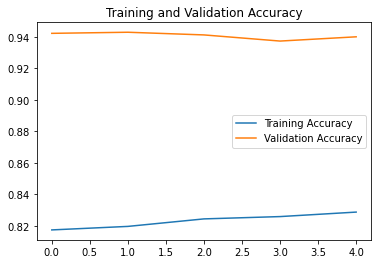

In [21]:
# 绘制准确率 acc 曲线
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

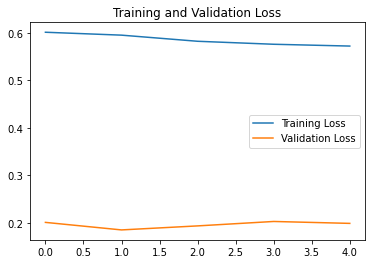

In [22]:
# 绘制损失函数 loss 的曲线
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 6. 应用模型对新数据进行预测

经过上面的步骤，“六步法”得到了很好的补充，使用 tf.keras 实现神经网络的方法也更加的完善。但是要想让模型可用，还需要编写一套应用程序，让模型可用于对新数据的预测。

对于手写数字识别模型，那么就需要让训练好的模型可以对新的手写的数字进行识别。可以使用 `model.predict()` 函数来对新的输入特征进行预测，该函数有以下几个常用参数：
 + x：输入数据，Numpy 数组（或者 Numpy 数组的列表，如果模型有多个输出）
 + batch_size：整数，由于 GPU 的特性，batch_size 最好选用 8，16，32，64……，如果未指定，默认为 32
 + verbose: 日志显示模式，0 或 1
 + steps: 声明预测结束之前的总步数（批次样本），默认值 None
 + 返回：预测的 Numpy 数组（或数组列表）
 
要实现一个应用程序进行预测，大致分为三个步骤：
 + 复现模型
 + 加载参数
 + 预测结果

#### 6.1 复现模型

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#### 6.2 加载参数

In [24]:
model_save_path = './checkpoint/mnist.ckpt'
model.load_weights(model_save_path)

#### 6.3 预测结果

在 `./data/digits` 目录中，存放着 10 个新的手写数字图片 `0.png`、`1.png` …… `9.png`

这里要注意的是，预测数据，与训练用的数据格式不一致。
 + 训练模型时用的图片是 28 行 28 列的灰度图，而输入的预测数据则是任意尺寸的图片，因此需要先 resize 成 28 行 28 列的标准尺寸，并转换为灰度图；
 + 训练模型时用的数据集是黑底白字灰度图，而输入的预测数据则是白底黑字，因此需要让输入数据的每个像素点等于 255 减去当前像素值（相当于颜色取反）；
 + 此外，输入的预测数据还需要完成归一化，即对图片数据除以 255。

只有经过这两个步骤，才可以让从没见过的数字图片满足神经网络模型对输入风格的要求，这个过程叫做**预处理**。预处理的方法有很多，对于手写数字识别，还可以让输入图片变为只有黑色和白色的高对比度图片，这样可以在保留图片有用信息的同时，滤去背景噪声，图片更干净。

由于神经网络训练时，都是按照 batch 送入网络的，所以输入数据进入 predict 函数之前还需要在前面添加 1 个维度，从 28 行 28 列的二维数据，变为 1 个 28 行 28 列的三维数据。

./data/digits/8.png


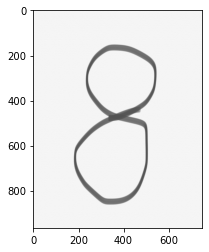

In [25]:
# 随机从选一个手写数字图片
rand_idx = np.random.randint(0, 10)
img_path = './data/digits/{}.png'.format(rand_idx)
im = plt.imread(img_path)
plt.imshow(im)
print(img_path)
plt.show()

In [26]:
# 获取图片
img = Image.open(img_path)
# resize 图像大小为 28x28
img = img.resize((28, 28), Image.ANTIALIAS)
# 转换为灰度图
img_arr = np.array(img.convert('L'))
# 颜色取反，原来是白底黑字，转换为黑底白字
img_arr = 255 - img_arr
# 归一化
img_arr = img_arr / 255.0 
# 将 img_arr 的维度从 [28, 28] 转换为 [1, 28, 28]
x_predict = img_arr[tf.newaxis, ...] 
# 预测，并得到所有值的概率
result = model.predict(x_predict)
# 得到最大概率值，即预测结果
pred = tf.argmax(result, axis=1) 
tf.print('predict:', pred)

predict: [8]
